# Introduction, documentation and other comments
The original version was made on 04/25/2022 by Rafael da Fonte Freire (rafaeldafontefreire@gmail.com) as part of Data Pipeline team of the 11th semester of the Air Partners ADE project at Olin College. Here is the assumption test further documenting the original version:


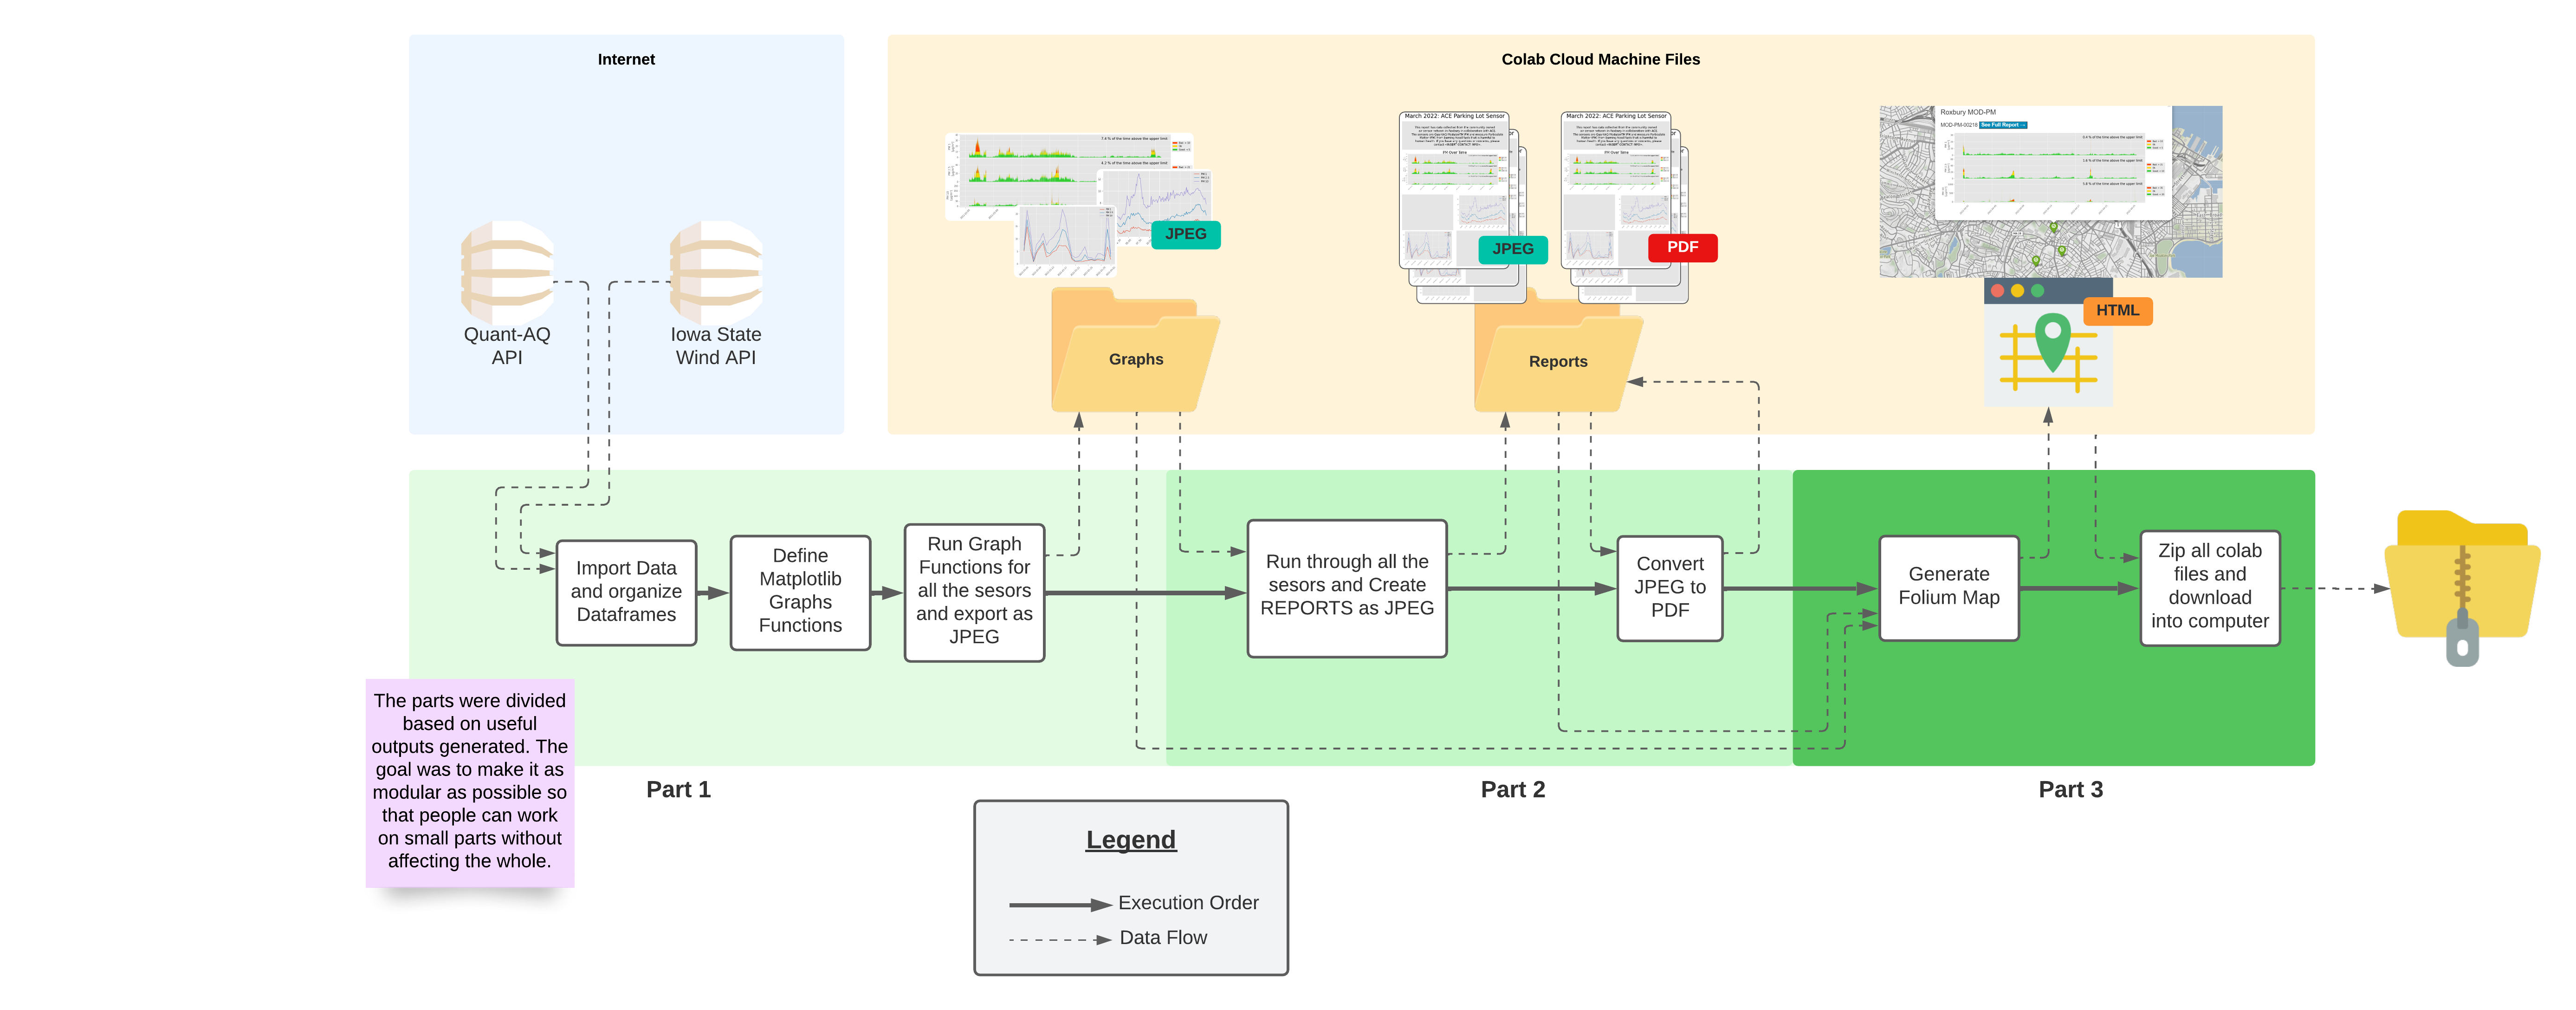

Running this code:



1.   Change the year and month to the desired period in the "Initial Inputs" Section.
2.   Run All.
3.   After it is done running, it will start downloading a zip file with all the graphs, reports and the map generated. Make sure to extract the file before start using it.



---
Tips:

*   This program was designed to be easily modifiable & quickly adapt to feedback from ACE by breaking it down into small, simple functions. For it to still work this way, make sure to:
  *   Keep the program modular - Avoid making codes that will not function if another part of the code has changed
  *   Keep it easy to understand - This program has to be quickly understood by the next teams, so avoid using complicated new libraries, for example, even if it is more efficient.




---
To do: <br>
Part 1:
*   Import Wind Data
*   Make wind data Graph
*   Make Calendar Plot

Part 2:
*   Aesthetics of the report
*   Written content

Part 3:
*   Use data to modify markers in the map to highlight alarming pollution levels.
*   Validate usability with ACE.





# Initial Inputs !!Configure Here!!

In [2]:
month = 4
year = 2022

Quant_AQ_API_key = "VSZMMY8VT8FIRNIIXWTD2G7V"

# Part 1 - Import Data and Generate Graphs

## Import QuantAQ and Wind Data

### List of sensors and connection status

In [3]:
import pandas as pd
import quantaq
from quantaq.utils import to_dataframe
from datetime import datetime,timedelta
client = quantaq.QuantAQAPIClient(api_key=Quant_AQ_API_key)
def sensor_list():
  devices_raw = to_dataframe(client.devices.list(filter="city,like,%_oxbury%"))
  devices_simplified = devices_raw.iloc[:,[4,3,11,15,16,5,7,8,10,12]]
  return devices_simplified,devices_raw

nowutc = datetime.utcnow()
df_sensor_list,devices_raw = sensor_list()
df_sensor_list.head(5)

,id,description,sn,geo.lat,geo.lon,last_seen,n_datapoints,outdoors,private,status
0,403,Roxbury MOD-PM,MOD-PM-00216,NaN,NaN,2022-03-04T19:19:38.816220,77803,True,True,ACTIVE
1,405,Roxbury MOD-PM,MOD-PM-00218,NaN,NaN,2022-06-16T15:52:00.718973,155291,True,False,ACTIVE
2,408,Roxbury MOD-PM,MOD-PM-00221,NaN,NaN,2022-03-04T19:21:38.505520,85620,True,True,ACTIVE
3,418,Roxbury MOD-PM,MOD-PM-00231,NaN,NaN,2022-03-04T19:28:28.055324,86521,True,True,ACTIVE
4,398,Roxbury MOD-PM,MOD-PM-00211,NaN,NaN,2022-03-04T19:16:57.919527,63857,True,True,ACTIVE


### PMs of a specific sensor in a specific month

In [4]:
import pandas as pd
import quantaq
from quantaq.utils import to_dataframe
from datetime import datetime, timedelta
client = quantaq.QuantAQAPIClient(api_key=Quant_AQ_API_key)

year_month = str(year) + '-0' + str(month) if month<=9 else str(year) + '-' + str(month)

def data_month(month_int,year_int_YYYY,sensor_sn):        
    df = []
    if month_int == 12:
        start_date = '{0}-{1}-01'.format(year_int_YYYY, month_int)
        end_date = '{0}-{1}-01'.format(year_int_YYYY+1, 1)
    else:
        start_date = '{0}-{1}-01'.format(year_int_YYYY,month_int)
        end_date = '{0}-{1}-01'.format(year_int_YYYY,month_int+1)
    number_of_days = len(pd.date_range(start=start_date,end=end_date))
    c = 1
    for each in pd.date_range(start=start_date,end=end_date):
        df.append(to_dataframe(client.data.bydate(sn=sensor_sn, date=str(each.date()))))
        print('\r Day Progress: {0} / {1}'.format(c,number_of_days), end='', flush=True)
        c+=1
    df = pd.concat(df)
    if not df.empty:
      df_simplified = df.iloc[:,[0,1,2,4,5,7,8]]
      return df_simplified
    else:
      return df

list_of_sensors_sn = list(df_sensor_list.sn)
total_amount_of_sensor = len(list_of_sensors_sn)
dic_of_PM_df_by_sn = {}

sensor_count = 1
for sn in list_of_sensors_sn:
  print('\rSensor Progress: {0} / {1}\n'.format(sensor_count,total_amount_of_sensor), end='', flush=True)
  df = data_month(month,year,sn) 
  # Add month column in df so extraneous days can be filtered out later
  df['month'] = [df.iloc[row]['timestamp_local'].month for row in range(df.shape[0])]
  dic_of_PM_df_by_sn[sn] = df
  sensor_count+=1
print('\nDone!')

#sn='MOD-PM-00218';data_month(3,2022,sn) # test

Sensor Progress: 1 / 21
Sensor Progress: 2 / 21
Sensor Progress: 3 / 21
Sensor Progress: 4 / 21
Sensor Progress: 5 / 21
Sensor Progress: 6 / 21
Sensor Progress: 7 / 21
Sensor Progress: 8 / 21
Sensor Progress: 9 / 21
Sensor Progress: 10 / 21
Sensor Progress: 11 / 21
Sensor Progress: 12 / 21
Sensor Progress: 13 / 21
Sensor Progress: 14 / 21
Sensor Progress: 15 / 21
Sensor Progress: 16 / 21
Sensor Progress: 17 / 21
Sensor Progress: 18 / 21
Sensor Progress: 19 / 21
Sensor Progress: 20 / 21
Sensor Progress: 21 / 21
 Day Progress: 31 / 31
Done!


### Import Wind Data

In [5]:
from calendar import monthrange
from data_analysis.iem import fetch_data

def get_start_end_dates(month_int, year_int_YYYY):
    # get number of days in month_int of that year
    no_of_days = monthrange(year_int_YYYY, month_int)[1]
    # get start and end dates in type datetime
    start_date = datetime(year_int_YYYY, month_int, 1)
    end_date = datetime(year_int_YYYY, month_int, no_of_days)
    return start_date, end_date

start, end = get_start_end_dates(month, year)
iem_df = fetch_data(start, end)
iem_df.head(5)

,station,valid,drct,sped
0,BOS,2022-04-01 00:00,200.0,21.85
1,BOS,2022-04-01 00:05,210.0,23.00
2,BOS,2022-04-01 00:10,210.0,24.15
3,BOS,2022-04-01 00:15,210.0,23.00
4,BOS,2022-04-01 00:20,210.0,20.70


## Matplotlib Graphs Functions Definition

In [6]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Calendar Plot

In [7]:
import calendar
import matplotlib
import seaborn as sns

calendar.setfirstweekday(6) # Sunday is 1st day in US
w_days = 'Sun Mon Tue Wed Thu Fri Sat'.split()
m_names = '''
January February March April
May June July August
September October November December'''.split()

class CalendarPlot(object):
    def __init__(self, year, month):
        self.year = year
        self.month = month
        self.cal = calendar.monthcalendar(year, month)
        # monthcalendar creates a list of lists for each week
        # Save the PM values data in the same format
        self.pm_vals = [[0 for day in week] for week in self.cal]

    def _get_colors(self):    
        """
        Get palettable colors from Seaborn
        """
        bmap = sns.color_palette('Spectral_r', 20)
        return bmap

    def _monthday_to_index(self, day):
        """
        The index of the day in the list of lists
        """
        for week_n, week in enumerate(self.cal):
            try:
                i = week.index(day)
                return week_n, i
            except ValueError:
                pass
         # couldn't find the day
        raise ValueError("There aren't {} days in the month".format(day))

    def add_pm_vals(self, df):
        """
        assign PM value for each day from DataFrame
        """
        end_date = calendar.monthrange(self.year, self.month)[1]
        start_date = end_date - df.shape[0]
        # Doing days in reversed order, for the case that a sensor was 
        # installed in middle of month
        for day in reversed(range(start_date, end_date)):
            week, w_day = self._monthday_to_index(day+1)
            self.pm_vals[week][w_day] = df.iloc[day - (start_date)]['pm25']

    def show(self):
        """
        create the calendar
        """
        color_list = self._get_colors()
        color_len = len(color_list)

        # Create grid of subplots, where each subplot is a day in the calendar
        f, axs = plt.subplots(len(self.cal), 7, sharex=True, sharey=True)
        for week, ax_row in enumerate(axs):
            for week_day, ax in enumerate(ax_row):
                ax.set_xticks([])
                ax.set_yticks([])
                if self.cal[week][week_day] != 0:
                    ax.text(.5, .5,
                            str(self.cal[week][week_day]),
                            fontsize=16,
                            verticalalignment='center',
                            horizontalalignment='center')
                    # TODO: change this scale to make sense with PM 2.5 values
                    pm_val = self.pm_vals[week][week_day]
                    if pm_val >= 12:
                        ax.set_facecolor(color_list[-1])
                    elif pm_val == 0:
                        ax.set_facecolor('white')
                    else:
                        ax.set_facecolor(color_list[int(self.pm_vals[week][week_day])])

        # use the titles of the first row as the weekdays
        for n, day in enumerate(w_days):
            axs[0][n].set_title(day)

        # Place subplots in a close grid
        f.subplots_adjust(hspace=0)
        f.subplots_adjust(wspace=0)
        f.subplots_adjust(right=0.8)
        f.suptitle(m_names[self.month-1] + ' ' + str(self.year) + '\n',
                   fontsize=16, fontweight='bold')
        
        # Add colorbar
        cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
        norm = matplotlib.colors.Normalize(vmin=0, vmax=20)
        f.colorbar(matplotlib.cm.ScalarMappable(norm=norm, 
                                                cmap='Spectral_r'), 
                                                cax=cbar_ax, 
                                                label='Concentrations of PM2.5 [μg/m³]')

        #plt.show()

In [8]:
def calendar_plot(data_PM):
    # Reformat data_PM so that only data from that month is plotted
    data_PM = data_PM.set_index('timestamp_local').resample('1D').mean()
    data_PM = data_PM[data_PM['month'] == month]
    # Create calendar plot
    cal = CalendarPlot(year, month)
    cal.add_pm_vals(data_PM)
    cal.show()

### Timeplot with thresholds

In [9]:
from IPython.core.pylabtools import figsize
from matplotlib.offsetbox import AnchoredText

def timeplot_threshold(data_PM):
  def detect_inactive_sensor(df, timedelta_to_consider_inactive_in_minutes):
    inactive = [0]
    for i in range(1, len(df)):
      timedelta = (df.timestamp_local.iloc[i] - df.timestamp_local.iloc[i-1]).total_seconds()/60
      if timedelta >= timedelta_to_consider_inactive_in_minutes:
        inactive.append(1)
        inactive[i-1] = 1
      else:
        inactive.append(0)
    df['inactive'] = inactive

  detect_inactive_sensor(data_PM,5)

  def thresholds_subplots(plot_number, threshold_lower,threshold_upper):
    if plot_number == 0:
      pm = pm1
      ylabel = 'PM 1'
      ylim = (0, 25)
    elif plot_number == 1:
      pm = pm25
      ylabel = 'PM 2.5'
      ylim = (0, 100)
    elif plot_number == 2:
      pm = pm10
      ylabel = 'PM 10'
      ylim = (0, 200)
    axs[plot_number].fill_between(ts, pm, 0, where=(data_PM.inactive == 0), facecolor="limegreen", interpolate=True, alpha=1,label='Good: < {}'.format(threshold_lower))
    axs[plot_number].fill_between(ts, pm, threshold_lower, where=(data_PM.inactive == 0) & (pm >= threshold_lower), facecolor="gold", interpolate=False, alpha=1,label='Ok')
    axs[plot_number].fill_between(ts, pm, threshold_upper, where=(pm >= threshold_upper), facecolor="orangered", interpolate=False, alpha=1,label='Bad: > {}'.format(threshold_upper))
    axs[plot_number].set_ylabel('{}\n[μg/m³]'.format(ylabel))
    axs[plot_number].set_ylim(ylim)
    
    handles, labels = axs[plot_number].get_legend_handles_labels()
    axs[plot_number].legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.0,0.5),loc = 'center left')

    try:
      percent_above_upper = (pm >= threshold_upper).value_counts(True).sort_values()[1]
    except:
      percent_above_upper = 0

    at = AnchoredText(
        "{} % of the time above the upper limit".format(round((percent_above_upper * 100),1)), prop=dict(size=15), frameon=False, loc='upper right')
    #at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axs[plot_number].add_artist(at)

  pm1 = data_PM.pm1
  pm25 = data_PM.pm25
  pm10 = data_PM.pm10
  ts = data_PM.timestamp_local

  fig2, axs = plt.subplots(3, sharex=True, sharey=False, figsize=(17,6))
  plt.subplots_adjust(hspace=.0)
  plt.xticks(rotation=45)

  # Threshold values assigned according to annual EPA standards
  thresholds_subplots(0, 5, 10)
  thresholds_subplots(1, 10, 20)
  thresholds_subplots(2, 20, 35)

  # Hide x labels and tick labels for all but bottom plot.
  for ax in axs:
      ax.label_outer()

### Time of day plot

In [10]:
from matplotlib.ticker import MaxNLocator

def time_of_day_plot(dataPM):
  dataPM_10min = dataPM.set_index('timestamp_local').resample('10T').mean()
  dataPM_10min['hour_minute'] = dataPM_10min.index.strftime('%H:%M')
  dataPM_10min = dataPM_10min.groupby('hour_minute').mean()

  fig,axes=plt.subplots(1,1,figsize=(8,5))
  axes.plot(dataPM_10min.index,dataPM_10min.pm1, label = 'PM 1')
  axes.plot(dataPM_10min.index,dataPM_10min.pm25, label = 'PM 2.5')
  axes.plot(dataPM_10min.index,dataPM_10min.pm10, label = 'PM 10')
  axes.xaxis.set_major_locator(MaxNLocator(15.8)) 
  axes.legend()
  axes.set_ylabel("[μg/m³]")
  for tick in axes.get_xticklabels():
      tick.set_rotation(45)

### Daily average plot

In [11]:
def daily_average_plot(dataPM):
  dataPM_day = dataPM.set_index('timestamp_local').resample('1D').mean()
  plt.style.use('ggplot')

  fig,axes=plt.subplots(1,1,figsize=(8,5))
  axes.plot(dataPM_day.pm1, label = 'PM 1')
  axes.plot(dataPM_day.pm25, label = 'PM 2.5')
  axes.plot(dataPM_day.pm10, label = 'PM 10')
  axes.set_ylabel("[μg/m³]")  
  axes.legend()
  for tick in axes.get_xticklabels():
      tick.set_rotation(45)

### Wind polar plot

In [12]:
%load_ext autoreload
%autoreload 2

from data_analysis.dataviz import OpenAirPlots

def wind_polar_plot(data_PM):
    # Get data only from specified month
    data_PM = data_PM[data_PM['month'] == month]
    
    # Add wind speed and wind direction columns to dataframe
    def replace_with_iem(df, iem_df, is_tz_aware=True):
        """
        Wind speed and wind direction from the QuantAQ sensors are unreliable so we replace them with data from
        the IEM meteorology sensors.
        :param df: (pd.DataFrame) dataframe containing sensor data
        :param iem_df: (pd.DataFrame) dataframe containing meteorology data
        :param is_tz_aware: (optional bool) True if the raw, string representations of timestamps in df are time zone-aware
        """
        #convert str representation of timestamps to datetime
        iem_df = iem_df.assign(timestamp=pd.to_datetime(iem_df['valid']))

        #IEM data is recorded once every 5 mins, quantAQ data recorded once per minute, need to fill in rows in IEM data
        # to match quantAQ. So, for every IEM timestamp, we add 4 copies of the IEM data so that the IEM and QuantAQ dataframes
        # have the same number of rows:

        #create new timestamp column that matches the timestamps for the quantAQ data
        start, end = df.timestamp.min(), df.timestamp.max()
        if not is_tz_aware:
            start, end = start.tz_localize(None), end.tz_localize(None)
        dates = pd.date_range(start=start, end=end, freq='1Min')
        #fill new empty rows with the last valid value
        iem_df['timestamp'] = iem_df['timestamp'].dt.round('1Min') # this operation sometimes adds duplicates by rounding to the same minute.
        iem_df = iem_df.set_index('timestamp')
        # delete duplicate timestamps before reindexing, or pandas complains
        iem_df = iem_df.loc[~iem_df.index.duplicated(), :]

        #reindex meteorology data to match original dataframe
        iem_df = iem_df.reindex(dates, method='pad')

        #convert timestamp index back into a column
        iem_df = iem_df.reset_index().rename(columns={"index": "timestamp"})
        #some values might be NaN due to timestamp mismatch, fill them with the next valid value
        iem_df = iem_df.fillna(method='bfill')

        #assign the new wind direction and wind speed columns to the quantAQ dataframe
        df = df.assign(wind_dir=iem_df['drct'])
        df = df.assign(wind_speed=iem_df['sped'] * (1609/3600))  #converting to m/s, 1609 meters per mile, 3600 seconds per hr
        return df
    
    df = replace_with_iem(data_PM, iem_df)

    #df = df.rename(columns={"timestamp_local": "date", "wind_speed": "ws", "wind_dir": "wd"})
    #df.wd = df.wd.replace(0.0, 360.0)
    df = df[['timestamp_local', 'wind_speed', 'wind_dir', 'pm25']]
    # Format the dataPM to be read in R and plot wind data
    
    global silly_string
    
    air_plt = OpenAirPlots()
    air_plt.polar_plot(df, '2022-04/Graphs/wind_polar_plot/', ['pm25'])
    #ro.r.polarPlot(dataPM, pollutant = p, main = f"{p.upper()} Polar Plot")
    
    # Take current image, save image again using matplotlib
    img = plt.imread(fname='2022-04/Graphs/wind_polar_plot/_polar_pm25.png')
    plt.figure()
    plt.imshow(img)
    plt.grid(None)
    plt.xticks([])
    plt.yticks([])

## Generate and Export Graphs

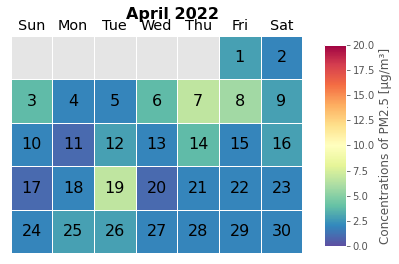

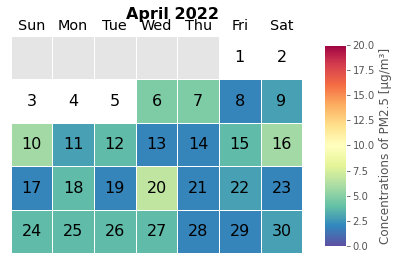

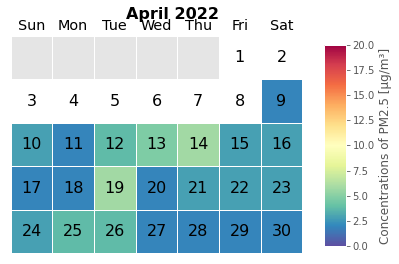

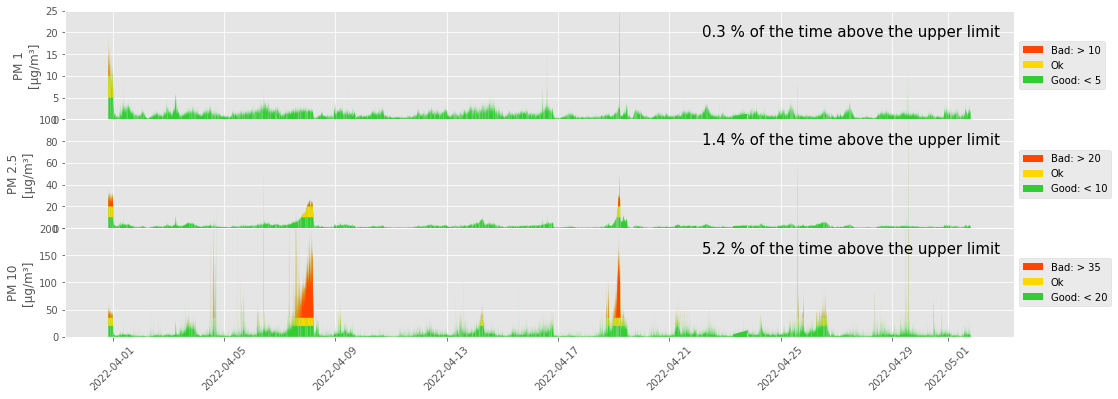

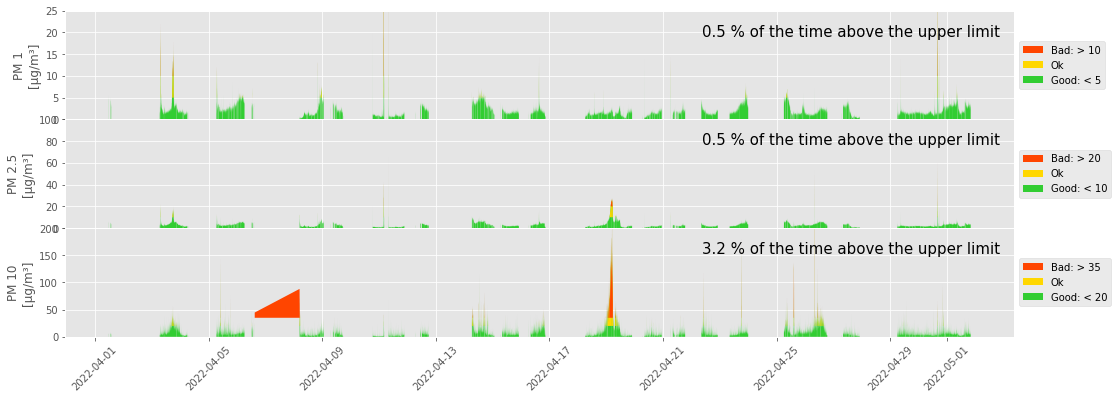

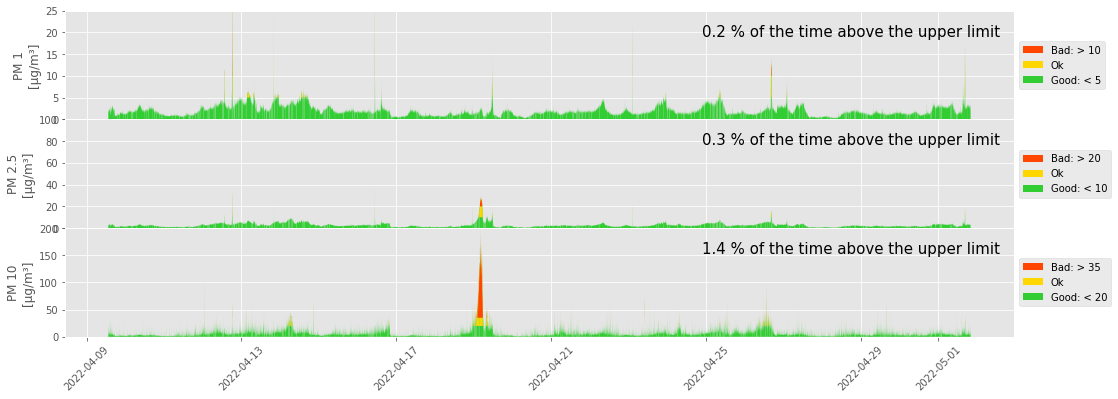

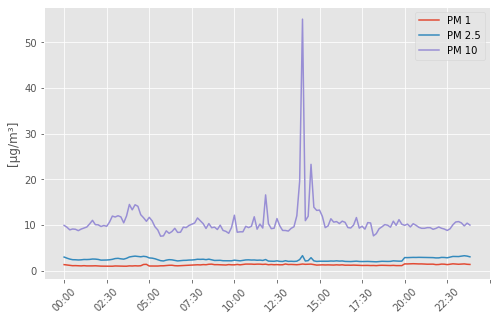

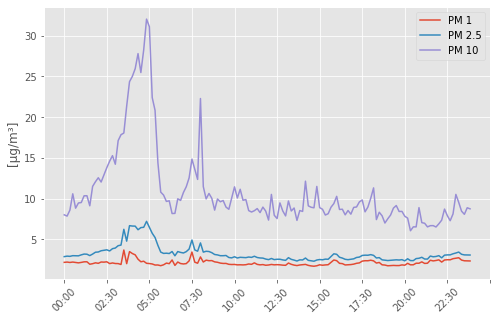

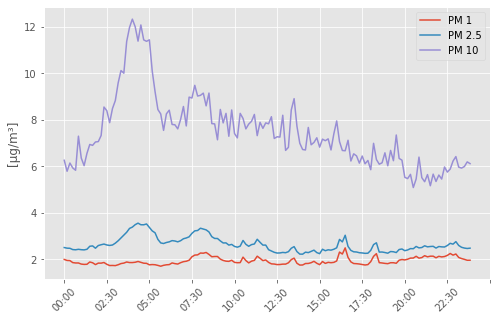

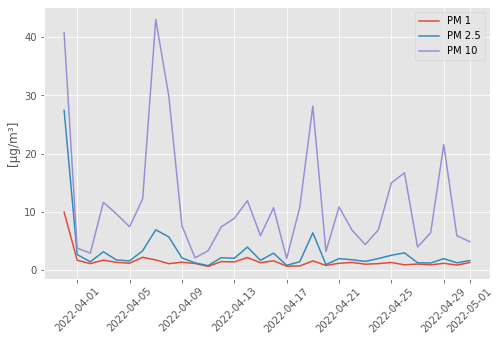

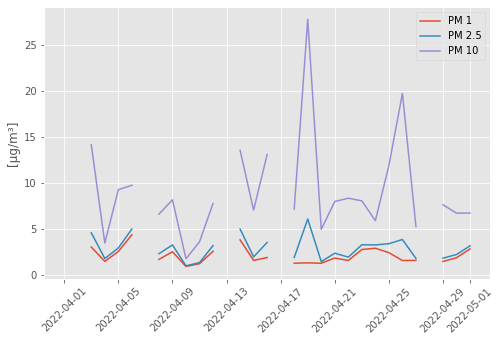

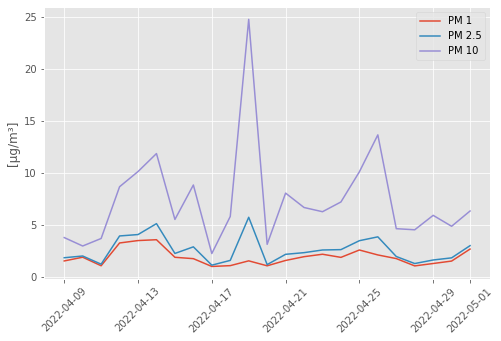

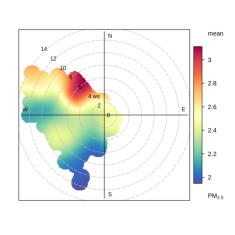

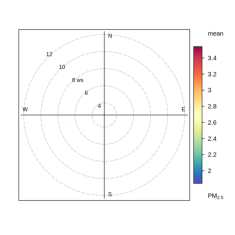

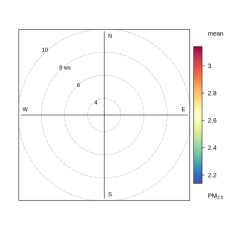

In [13]:
import os
def plot_and_export(plot_function):
  try:
    os.mkdir('{}'.format(year_month))
  except:
    pass
  try:
    os.mkdir('{}/Graphs/'.format(year_month))
  except: 
    pass
  try:
    os.mkdir('{}/Graphs/'.format(year_month)+str(plot_function.__name__))
  except: # Forgive my crime here, but it just avoids errors if the directory already exists
    pass
  for sn in list_of_sensors_sn:
    if not dic_of_PM_df_by_sn[sn].empty:
      plot_function(dic_of_PM_df_by_sn[sn])
      plt.savefig('{1}/Graphs/{2}/{0}_{1}_{2}.jpeg'.format(sn,year_month,str(plot_function.__name__)), bbox_inches='tight',dpi = 300)

plot_and_export(calendar_plot)
plot_and_export(timeplot_threshold)
plot_and_export(time_of_day_plot)
plot_and_export(daily_average_plot)
plot_and_export(wind_polar_plot)

# Part 2 - Import Graphs and Generate Reports

## Generate Reports as JPEG

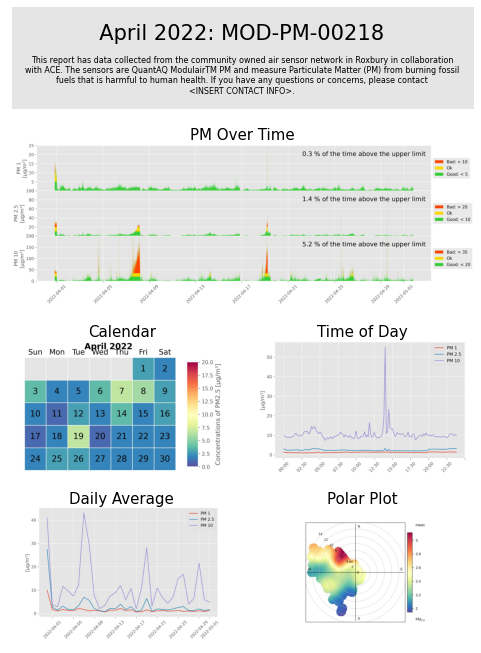

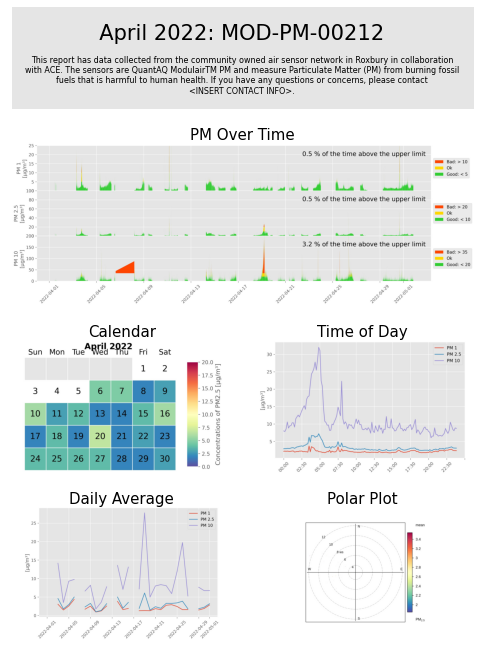

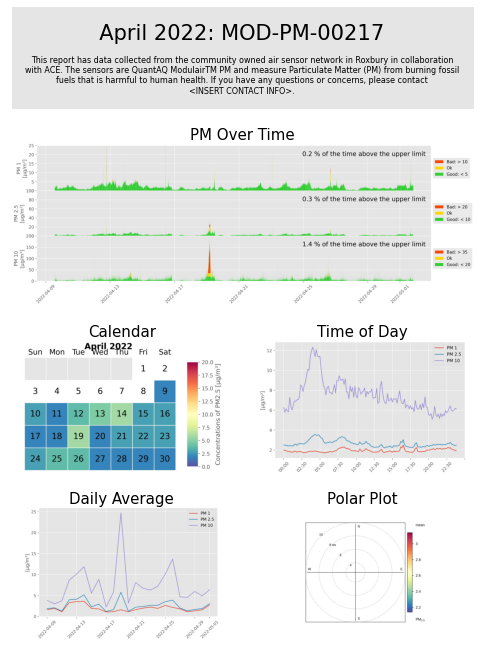

In [14]:
import matplotlib.image as mpimg

def generate_report(dataPM, sn):
  ## Figure config    
  def import_and_plot_img(plot_function):
    plt.grid(0);plt.yticks([]);plt.xticks([])
    img = mpimg.imread('{1}/Graphs/{2}/{0}_{1}_{2}.jpeg'.format(sn,year_month,str(plot_function.__name__)))
    plt.imshow(img)
  fig = plt.figure(figsize=(8.3,11.7))
  grid = plt.GridSpec(20, 6, wspace=0.3, hspace=10)
  graph_title_position = 0.98
  graph_title_size = 15

  ## Header
  fig.add_subplot(grid[:4,:])
  plt.grid(0);plt.yticks([]);plt.xticks([])
  plt.title(
'This report has data collected from the community owned air sensor network in Roxbury in collaboration\n\
with ACE. The sensors are QuantAQ ModulairTM PM and measure Particulate Matter (PM) from burning fossil\n\
fuels that is harmful to human health. If you have any questions or concerns, please contact\n\
<INSERT CONTACT INFO>.'
      ,fontsize=8, y=0.1)
  dic_month = {1:"January",2:"February",3:"March",4:"April",5:"May",6:"June",
               7:"July",8:"August",9:"September",10:"October",11:"November",12:"December"}
  plt.suptitle('  {0} {1}: {2}'.format(dic_month[month],year,sn),fontsize=21, y=0.86)

  ## Timeplots with Thresholds
  fig.add_subplot(grid[4:10,:])
  plt.title('PM Over Time', y=graph_title_position,fontsize=graph_title_size)
  import_and_plot_img(timeplot_threshold)
  

  ## Calendar plot
  fig.add_subplot(grid[10:15,:3])
  plt.title('Calendar', y=graph_title_position,fontsize=graph_title_size)
  import_and_plot_img(calendar_plot)

  ## Time of day plot
  fig.add_subplot(grid[10:15,3:6])
  plt.title('Time of Day', y=graph_title_position,fontsize=graph_title_size)
  import_and_plot_img(time_of_day_plot)

  ## Daily average plot
  fig.add_subplot(grid[15:20,:3])
  plt.title('Daily Average', y=graph_title_position,fontsize=graph_title_size)
  import_and_plot_img(daily_average_plot)

  ## Polar plot
  fig.add_subplot(grid[15:20,3:6])
  plt.title('Polar Plot', y=graph_title_position,fontsize=graph_title_size)
  import_and_plot_img(wind_polar_plot)

try:
  os.mkdir('{}/Reports'.format(year_month))
except: # Forgive my crime here, but it just avoids errors if the directory already exists
  pass
for sn in list_of_sensors_sn:
  if not dic_of_PM_df_by_sn[sn].empty:
    generate_report(dic_of_PM_df_by_sn[sn],sn)
    plt.savefig('{1}/Reports/{0}_{1}_{2}.jpeg'.format(sn,year_month,str('Report')), bbox_inches='tight',dpi = 300)


## Convert JPEG Reports to PDF

In [15]:
!pip install img2pdf
import img2pdf
def img2pdf_function(img_path,pdf_path):
    ImgFile = open(img_path,"rb")
    PdfFile = open(pdf_path,"wb")
    PdfFile.write(img2pdf.convert(ImgFile))
    ImgFile.close()
    PdfFile.close()

try:
  os.mkdir('{}/Reports/PDFs'.format(year_month))
except: # Forgive my crime here, but it just avoids errors if the directory already exists
  pass
for sn in list_of_sensors_sn:
  if not dic_of_PM_df_by_sn[sn].empty:
    img2pdf_function('{1}/Reports/{0}_{1}_{2}.jpeg'.format(sn,year_month,str('Report')),
                     '{1}/Reports/PDFs/{0}_{1}_{2}.pdf'.format(sn,year_month,str('Report')))

# Part 3 - Folium Grid Map

## Generate Map

In [19]:
import folium 
import math
import base64
def current_map(df_sensor_list):
    def check_sensor_status(sensor_last_seen):
        last_seen_utctime = datetime.fromisoformat(sensor_last_seen.replace("T"," "))
        acceptable_timedelta = timedelta(minutes=20)
        actual_timedelta = nowutc-last_seen_utctime
        if acceptable_timedelta>actual_timedelta:
            return True
        else:
            return False
    rox_latlng = [42.32877000000008, -71.08440999999993]
    map_rox = folium.Map(location=rox_latlng, zoom_start=13.5, tiles ='Stamen Terrain')
    for i in range(len(df_sensor_list)):
        if not math.isnan(df_sensor_list["geo.lat"][i]) and not dic_of_PM_df_by_sn[df_sensor_list.sn[i]].empty:

            if check_sensor_status(df_sensor_list.last_seen[i]):
                html = """
                      <h3>{2}<\h3>
                      <h4>{0}
                      <a href="../files/{1}/Reports/PDFs/{0}_{1}_Report.pdf" target="_blank">
                        <button type="button" style="background-color: #008CBA;color: white"><b>See Full Report →</b></button>
                      </a>
                      <\h4>
                      <img src="Graphs/timeplot_threshold/{0}_{1}_timeplot_threshold.jpeg" alt="Graph not found, make sure the folder is unziped" width="800" height="300">
                    """.format(df_sensor_list.sn[i],year_month,df_sensor_list.description[i])
                icon_color, icon_symbol = "green", "glyphicon-ok-circle"
                
            else:
                label = '**{0}** <br>\
                        Last Seen: {1}<br>'.format(df_sensor_list.description[i],df_sensor_list.last_seen[i])
                label = folium.Popup(label, parse_html=True)

            folium.Marker(
                    location = [df_sensor_list["geo.lat"][i],df_sensor_list["geo.lon"][i]],
                    popup=folium.Popup(folium.Html(html,script=True),max_width=1000),
                    icon=folium.Icon(color=icon_color, icon=icon_symbol)).add_to(map_rox)
    map_rox.save("{}/Roxbury_Grid_Map.html".format(year_month))
    return map_rox
map_rox = current_map(df_sensor_list)

#!!!!!!!!!!!!!!!!!!!!!!#
# THE GRAPHS AND PDFS WON'T WORK IN THIS MAP BECAUSE IT IS USING THE IMAGES ADRESSES AS IF IT WAS IN THE FOLDER TO BE DOWNLOADED.
# USE THIS MAP TO TEST OTHER CONFIGURATIONS. IF YOU WANT TO TEST WITH THE CHARTS, USE THE DOWNLOADED VERSION.
map_rox

## Zip and Download Everything

In [17]:
original_path = "/content/{}".format(year_month)
new_path = original_path+".zip"
!zip -r "$new_path" "$original_path"
from google.colab import files
files.download('{}.zip'.format(year_month))

	zip warning: name not matched: /content/2022-04

zip error: Nothing to do! (try: zip -r /content/2022-04.zip . -i /content/2022-04)


ModuleNotFoundError: No module named 'google'